In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [2]:
'''
To do:
current version removes Age, try again with imputation
convert to pipelines
lightgbm, compare to xgboost
'''

'\nTo do:\ncurrent version removes Age, try again with imputation\nconvert to pipelines\nlightgbm, compare to xgboost\n'

In [3]:
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder

#from sklearn.pipeline import Pipeline

# Data

In [4]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# almost all cabin values are missing
# won't be including these
# too bad, these could have been informative
print(train.shape)
train.isna().sum()

(891, 12)


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
# Tickets has 681 unique values.
# These might be informative if we knew more about what these values meant.
# But I'll just ignore them for now.
train.Ticket.nunique()

681

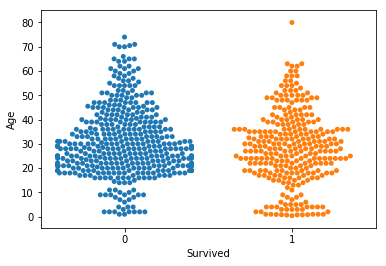

In [8]:
# not a ton to see here
# try with age removed and with an imputed age included
sns.swarmplot(x=train['Survived'],
              y=train['Age'])

In [9]:
features = ['Pclass','Sex','SibSp','Parch','Fare']
x = train[features]
x = pd.get_dummies(data=x, columns=['Sex'])
x = x.drop(['Sex_male'], axis=1)
y = train['Survived']
x.head()

# do the same to the test data
xtest = test[features]
xtest = pd.get_dummies(data=xtest, columns=['Sex'])
xtest = xtest.drop(['Sex_male'], axis=1)

# Performance Metrics

In [10]:
def scoreClassification(y,yhat,ndigits=4):
    
    # Accuracy
    accuracy = round((y==yhat).mean(),ndigits)
    print('accuracy:  ', accuracy)
    
    # Precision = percentage of yhat=1 that are correct
    yhat1 = (yhat==1)
    precision = round(y[yhat==1].mean(),ndigits)
    print('precision: ', precision)
    
    # Recall = percentage of y=1 that are correct
    y1 = (y==1)
    recall = round(yhat[y==1].mean(),ndigits)
    print('recall:    ', recall)
    
    # F1
    f1 = round(2/(1/recall+1/precision),ndigits)
    print('F1:        ', f1)
    
    # double check
    if round(accuracy_score(y,yhat),ndigits) != accuracy:
        print('double check accuracy, should be ', accuracy_score(y,yhat))
    if round(precision_score(y,yhat),ndigits) != precision:
        print('double check precision, should be ', precision_score(y,yhat))
    if round(recall_score(y,yhat),ndigits) != recall:
        print('double check recall, should be ', recall_score(y,yhat))
    if round(f1_score(y,yhat),ndigits) != f1:
        print('double check f1, should be ', f1_score(y,yhat))

# Logistic Regression

In [11]:
# model 1: logistic regression
# val and training sets both about 80% accurate
lr = LogisticRegression(random_state=0) # default L2 regression, default C=1 (lower C to increase regularization)
cv = cross_val_score(lr,x,y,cv=5)
print('cross validation accuracies:    ', cv)
print('cross validation mean accuracy: ', cv.mean())

lr.fit(x,y)
yhat_lr = lr.predict(x)
print('full training set scores:')

# contest is judged by accuracy, but just for completeness...
scoreClassification(y,yhat_lr)

cross validation accuracies:     [0.80446927 0.80337079 0.78089888 0.76966292 0.81460674]
cross validation mean accuracy:  0.7946017199171427
full training set scores:
accuracy:   0.7957
precision:  0.7632
recall:     0.6784
F1:         0.7183


# Random Forest

In [12]:
# model 2: random forest
# min_samples_leaf=5 overfits a bit (about 80% val accuracy compared to 85% full training set)
# min_samples_leaf=10 is about 80% vs 82.5%
rf = RandomForestClassifier(n_estimators=50, random_state=0, min_samples_leaf=10)
cv = cross_val_score(rf,x,y,cv=5)
print('cross validation accuracies:    ', cv)
print('cross validation mean accuracy: ', cv.mean())

# compare to performance on entire training set, would be nice if cross_val_score could do this for each fold?
# does a little better on the entire training set, nothing too suspicious here
rf.fit(x,y)
yhat_rf = rf.predict(x)
print('full training set scores:')

scoreClassification(y,yhat_rf)

cross validation accuracies:     [0.76536313 0.79775281 0.83707865 0.79775281 0.79775281]
cross validation mean accuracy:  0.7991400414286611
full training set scores:
accuracy:   0.8249
precision:  0.8633
recall:     0.6462
F1:         0.7391


# SVM

In [13]:
# model 3: SVM
# default values pretty bad, <70% accuracy
svm = SVC(random_state=0) # default rbf kernel, C=1 (decrease C to increase regularization)
cv = cross_val_score(svm,x,y,cv=5)
print('cross validation accuracies:    ', cv)
print('cross validation mean accuracy: ', cv.mean())

svm.fit(x,y)
yhat_svm = svm.predict(x)
print('full training set scores:')

scoreClassification(y,yhat_svm)

cross validation accuracies:     [0.58100559 0.71348315 0.67977528 0.68539326 0.67977528]
cross validation mean accuracy:  0.6678865105768628
full training set scores:
accuracy:   0.6801
precision:  0.6993
recall:     0.2924
F1:         0.4124


# XGBoost

In [ ]:
# model 4: gradient boosting
gb = XGBClassifier(random_state=0)
cv= cross_val_score(gb,x,y,cv=5)
print('cross validation accuracies:    ', cv)
print('cross validation mean accuracy: ', cv.mean())

# compare to performance on entire training set, would be nice if cross_val_score could do this for each fold?
# does a little better on the entire training set, nothing too suspicious here
gb.fit(x,y)
yhat_gb = gb.predict(x)
print('full training set scores:')

scoreClassification(y,yhat_gb)

# Neural Net (not a lot of data, just for show)

In [ ]:
# to do

# Submission

In [ ]:
# score of .80 would be top 1400
# .81 top 732
# .82 top 500
# 1.0 top 84
# score of .799 (default gradient boosting without age) places 1945

model = gb
predictions = model.predict(xtest)

output = pd.DataFrame({'PassengerID':test.PassengerId, 'Survived':predictions})
output.to_csv('titanicGradientBoost.csv', index=False)